# **💰 Bitcoin Price Prediction**

**📘 Foreword**

Cryptocurrencies have transformed global finance by introducing decentralized, trustless systems of value exchange. Among them, Bitcoin stands as the most established and volatile digital asset, often experiencing rapid price swings that outpace traditional equities. In 2020 alone, Bitcoin surged over 200%, reflecting how macroeconomic uncertainty, institutional adoption, and retail investor sentiment can catalyze extreme market behavior — only to be followed by sharp corrections.

This exceptional volatility, combined with the 24/7 nature of crypto markets, presents both an opportunity and a challenge. Human traders are limited by time, attention, and emotion. Automated trading strategies and data-driven models, however, can continuously monitor and respond to signals in real time — an essential advantage in high-frequency environments like crypto.

This project explores the application of machine learning models to Bitcoin price data, focusing on short-term price direction prediction (rise, fall, or sideways movement) using a classification framework. Inspired by traditional stock price indicators and extended by crypto-specific factors, we investigate whether established technical indicators, momentum strategies, and volume analysis can enhance signal quality in digital asset markets.

While this work is primarily a coding and modeling exercise for time-series problem solving, it draws relevance from real-world strategies such as those outlined in Cryptohopper’s guide to common cryptocurrency trading strategies, where moving averages, trend-following systems, and breakout strategies are commonly employed by both beginner and professional traders.

In building this project, the goal is not just predictive accuracy, but practical insight: understanding which features matter, how models perform under realistic constraints, and whether machine learning can enhance decision-making in fast-paced, data-dense environments.

In [78]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

100%|██████████| 112M/112M [00:04<00:00, 23.7MB/s] 

Extracting files...


Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/198


## 📊**2. Data Loading and Cleaning**

In [89]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/bitcoin-and-asset-trading/data/btcusd_1-min_data.csv.zstd', compression='zstd')
data.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [ ]:
# Ensure 'datetime' is parsed as datetime (if not already)
data['datetime'] = pd.to_datetime(data['datetime'])

# Set datetime as index
data.set_index('datetime', inplace=True)

# converting high-frequency (1-min interval) data to lower-frequency (daily) data
daily_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()


In [18]:
daily_data.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2012-01-01 00:00:00+00:00,4.58,4.84,4.58,4.84,10.000000
2012-01-02 00:00:00+00:00,4.84,5.00,4.84,5.00,10.100000
2012-01-03 00:00:00+00:00,5.00,5.32,5.00,5.29,107.085281
2012-01-04 00:00:00+00:00,5.29,5.57,4.93,5.57,107.233260
2012-01-05 00:00:00+00:00,5.57,6.46,5.57,6.42,70.328742


In [19]:
daily_data.describe()

,Open,High,Low,Close,Volume
count,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000
mean,16738.565324,17111.039075,16349.835895,16754.502586,7646.452125
std,23210.012705,23626.786947,22771.124075,23224.271811,9160.002471
min,4.380000,4.380000,3.800000,4.380000,0.000000
25%,420.700000,429.880000,414.000000,420.865000,2081.904510
50%,6497.910000,6630.000000,6370.000000,6501.770000,4824.456802
75%,26732.500000,27157.585000,26370.500000,26748.000000,10003.912641
max,108314.000000,109030.000000,106187.000000,106187.000000,127286.486533


# **📊 3. Exploratory Data Analysis (EDA)**


**Interactive Candlestick Plot**

An interactive candlestick chart, widely used by stock market users, shows price movements and volume. 
* Green/red candles indicate price increases/decreases, while volume bars highlight trading activity. Zoom and hover for detailed analysis.

In [45]:
import plotly.io as pio

pio.renderers.default = 'browser'  # <- Add this line before fig.show()


fig = go.Figure(data=[go.Candlestick(x=daily_data.index,
                                     open=daily_data['Open'],
                                     high=daily_data['High'],
                                     low=daily_data['Low'],
                                     close=daily_data['Close'],
                                     name='Candlestick')])

fig.add_trace(go.Bar(x=daily_data.index, y=daily_data['Volume'], name='Volume', yaxis='y2'))

fig.update_layout(
    title='Interactive Bitcoin Candlestick Chart with Volume (2012–2025)',
    yaxis_title='Price (USD)',
    yaxis2=dict(title='Volume', overlaying='y', side='right'),
    xaxis_title='Date',
    template='plotly_dark',
    height=600
)

fig.show()

**3.1 Time Series Plot of Bitcoin Close Price**

This plot illustrates the long-term trend of Bitcoin prices.
* Insight: Notable peaks in 2017, 2021 and late 2024 reflect bull runs, with recent data (up to 2025) showing continued volatility. 
* The model must account for these cycles.

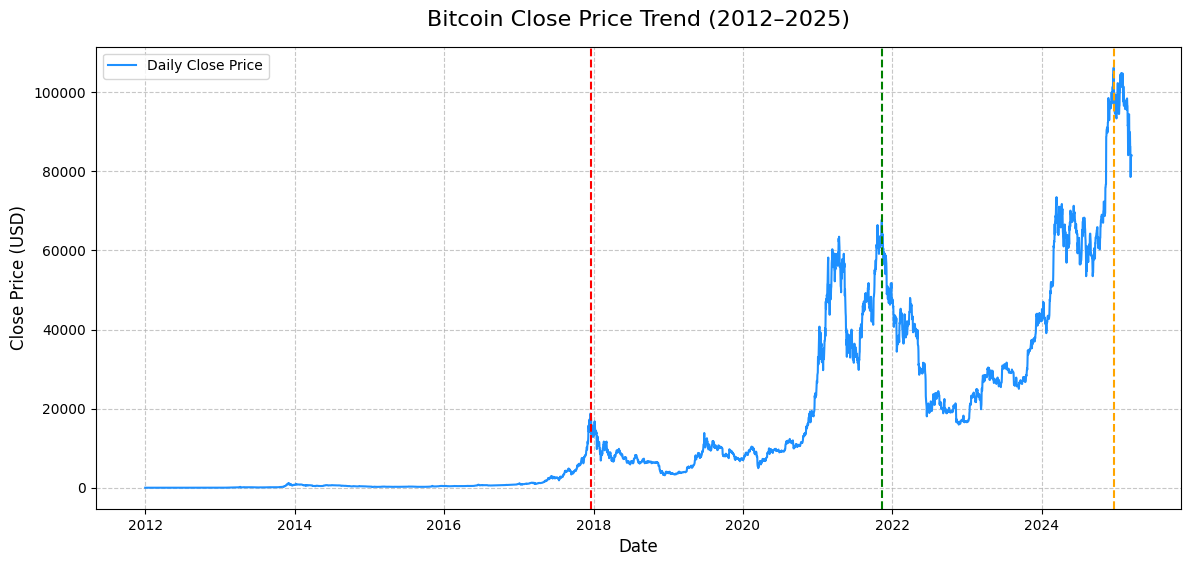

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Close'], label='Daily Close Price', color='#1E90FF')
plt.title('Bitcoin Close Price Trend (2012–2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.axvline(pd.Timestamp('2017-12-17'), color='red', linestyle='--')
plt.axvline(pd.Timestamp('2021-11-10'), color='green', linestyle='--')
plt.axvline(pd.Timestamp('2024-12-20'), color='orange', linestyle='--')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**3.2 Rolling Mean and Volatility**

This plot highlights trends and volatility using a 30-day rolling mean and standard deviation.

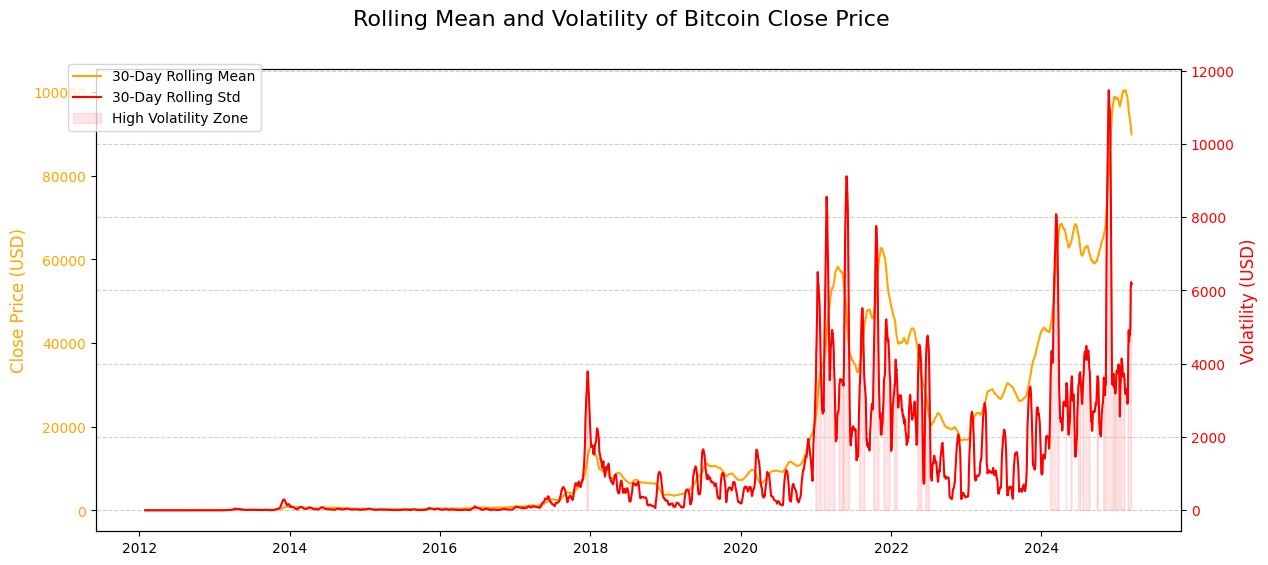

In [70]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Rolling mean
ax1.plot(daily_data.index, daily_data['Close'].rolling(30).mean(), color='orange', label='30-Day Rolling Mean')
ax1.set_ylabel('Close Price (USD)', fontsize=12, color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Rolling std
ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['Close'].rolling(30).std(), color='red', label='30-Day Rolling Std')
ax2.set_ylabel('Volatility (USD)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

volatility = daily_data['Close'].rolling(window=30).std()
threshold = volatility.quantile(0.90)  # top 10% volatility

plt.fill_between(daily_data.index, 0, volatility,
                 where=volatility > threshold,
                 color='red', alpha=0.1, label='High Volatility Zone')

fig.suptitle('Rolling Mean and Volatility of Bitcoin Close Price', fontsize=16)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**3.3 Distribution of Daily Returns**

Analyzes the distribution of daily percentage changes

* The histogram of Bitcoin’s daily returns reveals a leptokurtic distribution — a sharp peak with fat tails, indicating frequent small moves and occasional extreme events. 
* With a slightly negative skew and high kurtosis, the return pattern deviates significantly from a normal distribution, reinforcing Bitcoin's reputation as a volatile asset. 
* Risk metrics like VaR further quantify potential downside exposure for traders and investors.

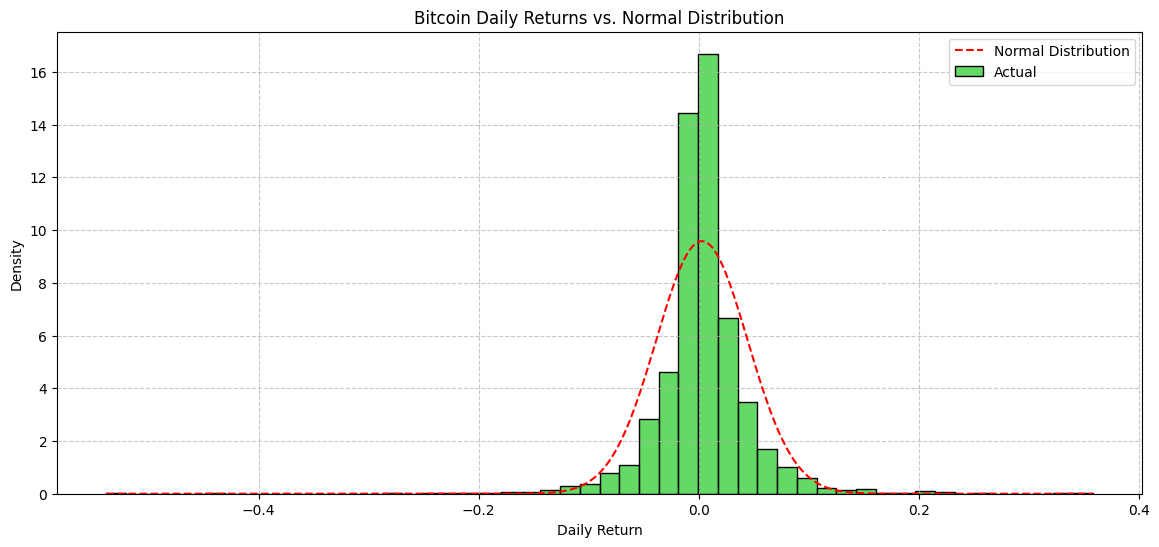

In [47]:
from scipy.stats import norm

daily_returns = daily_data['Close'].pct_change().dropna()

x = np.linspace(daily_returns.min(), daily_returns.max(), 1000)
normal_pdf = norm.pdf(x, daily_returns.mean(), daily_returns.std())

plt.figure(figsize=(14, 6))
sns.histplot(daily_returns, bins=50, kde=False, stat='density', color='#32CD32', label='Actual')
plt.plot(x, normal_pdf, label='Normal Distribution', color='red', linestyle='--')
plt.title('Bitcoin Daily Returns vs. Normal Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**3.4 Bitcoin Trading Volume Overtime** 

* Trading volume provides critical insight into market participation and sentiment. 
* Volume spikes often coincide with key market events, including halvings and all-time-highs. 
* Notably, volume surged during the 2013-2014 and 2021 bull runs, followed by quieter periods. Including rolling averages and event markers adds clarity to volatility-driven market phases.

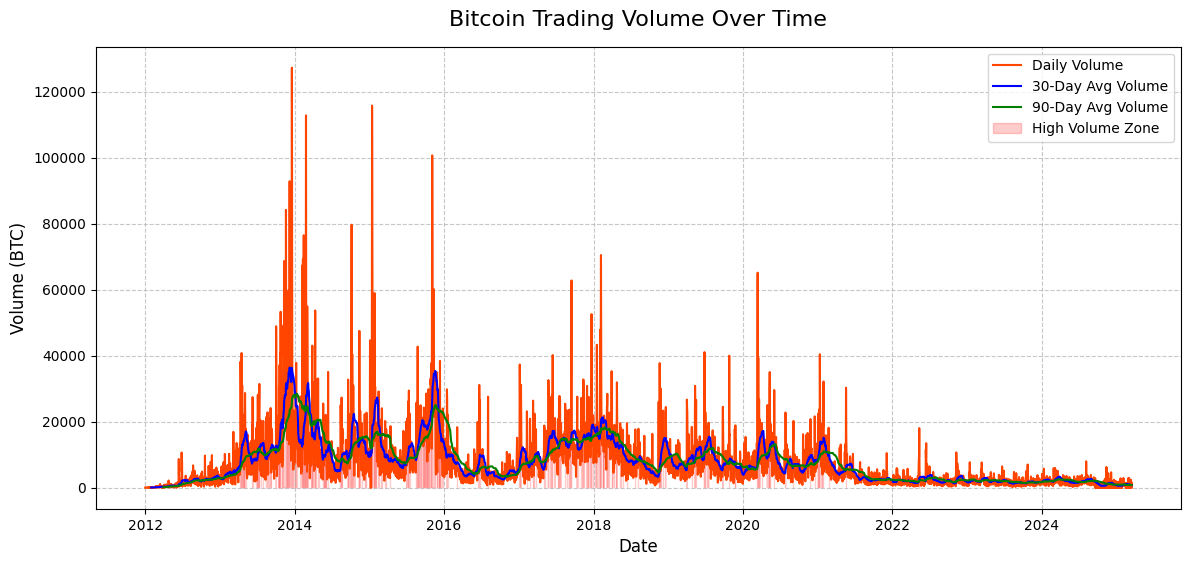

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['Volume'], label='Daily Volume', color='#FF4500')
plt.title('Bitcoin Trading Volume Over Time', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume (BTC)', fontsize=12)

rolling_volume = daily_data['Volume'].rolling(window=30).mean()
plt.plot(daily_data.index, rolling_volume, label='30-Day Avg Volume', color='blue')

rolling_volume = daily_data['Volume'].rolling(window=90).mean()
plt.plot(daily_data.index, rolling_volume, label='90-Day Avg Volume', color='green')

high_volume = daily_data['Volume'] > daily_data['Volume'].quantile(0.9)
plt.fill_between(daily_data.index, daily_data['Volume'], where=high_volume, color='red', alpha=0.2, label='High Volume Zone')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**3.5 MACD Plot** 

Analyzes Bitcoin’s trend momentum and potential reversal points

* MACD Crossovers as Entry/Exit Points: Buy signals (MACD crossing above signal line) and sell signals (MACD crossing below signal line) appear consistently and often precede significant price movements.

* Increased Activity After 2020: The frequency and amplitude of MACD fluctuations increased significantly after 2020, reflecting Bitcoin's growing volatility and active trading environment.

* Effective in Spotting Trend Reversals: Clusters of buy signals accurately preceded bullish runs (e.g., late 2020–2021), indicating MACD's effectiveness in spotting momentum shifts.

* False Signals in Sideways Markets: During periods of price consolidation or low volatility, several buy/sell signals occur in short succession—highlighting potential for false positives in sideways markets.

* Support for Momentum-Based Strategies: The indicator is especially useful for momentum traders seeking to ride trends and avoid entering during weakening momentum phases.

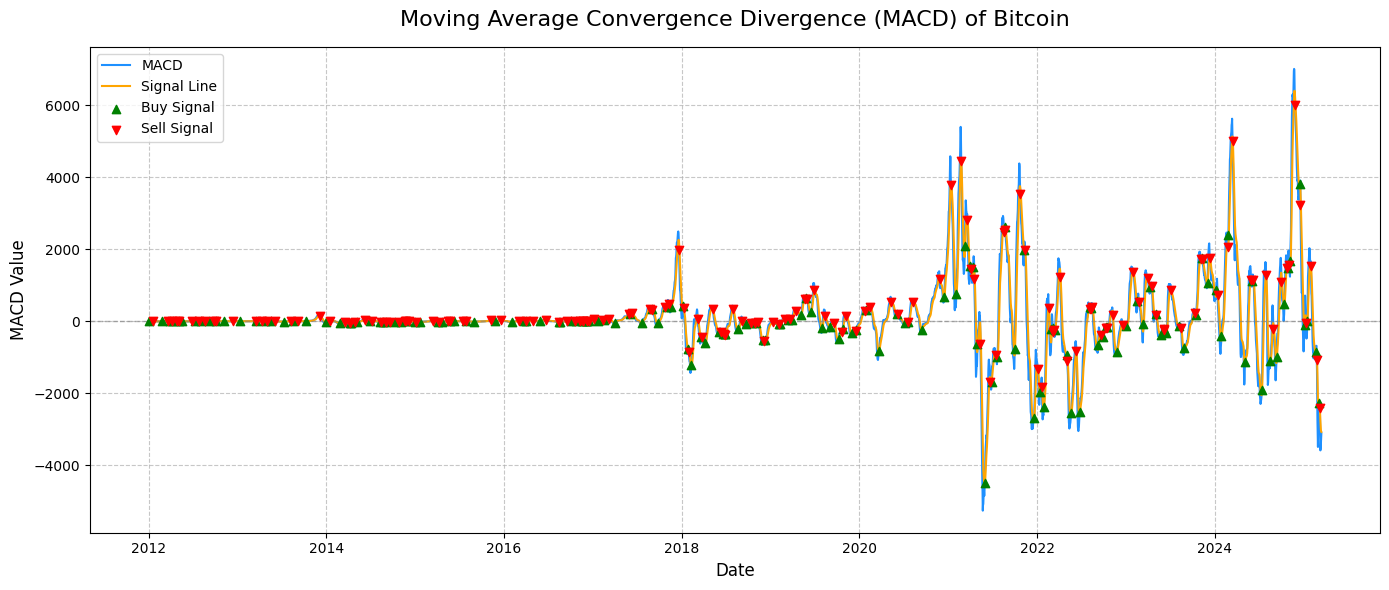

In [71]:
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

macd, signal_line = calculate_macd(daily_data['Close'])

# Identify Buy/Sell Signals
buy_signals = (macd > signal_line) & (macd.shift(1) <= signal_line.shift(1))
sell_signals = (macd < signal_line) & (macd.shift(1) >= signal_line.shift(1))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index[-len(macd):], macd, label='MACD', color='#1E90FF')
plt.plot(daily_data.index[-len(signal_line):], signal_line, label='Signal Line', color='#FFA500')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)

# Mark crossover points
plt.scatter(daily_data.index[-len(macd):][buy_signals], macd[buy_signals],
            marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(daily_data.index[-len(macd):][sell_signals], macd[sell_signals],
            marker='v', color='red', label='Sell Signal', zorder=5)

plt.title('Moving Average Convergence Divergence (MACD) of Bitcoin', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **🧹 4. Data Preprocessing**

In [75]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data.values.reshape(-1, 1))

In [76]:
# Create sequences (lookback window)
# Transforms time series into sequences of fixed length so the LSTM model can learn temporal patterns over a sliding window. 
seq_length = 90

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

In [77]:
# Train-Test Dataset Split

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (19220, 90, 1), y_train shape: (19220, 1)
X_test shape: (4805, 90, 1), y_test shape: (4805, 1)


# **🧹 5. LSTM Model Building**

Predict the next day’s Bitcoin price based on the past 90 days of prices. This is a sequence-to-one regression problem — perfect for an LSTM.

* 📏 Two LSTM layers (100 and 50 units) effectively capture short- and long-term dependencies in Bitcoin price trends.
* 🧠 Over 72,000 trainable parameters, with ~98% coming from the LSTM layers — highlighting their role in modeling sequence patterns.
* 🧱 Dropout layers (30% and 20%) help mitigate overfitting by randomly deactivating neurons during training.
* 🔗 Dense layers (25 and 1 units) transform learned temporal features into a final scalar price prediction.
* ⚖️ Model strikes a balance between complexity and performance, suitable for time series prediction without excessive overfitting risk.

In [79]:
# Define the model
model = Sequential([
    # Input + First LSTM Layer (returns sequences to feed into next LSTM)
    # The first LSTM layer captures long-term dependencies in the sequence. 
    Input(shape=(seq_length, 1)),
    LSTM(units=100, return_sequences=True, activation='tanh'),
    Dropout(0.3),  # Dropout for regularization

    # Second LSTM Layer (no sequences needed after this)
    # The second LSTM layer summarizes the sequence into a context vector — essentially a compressed version of the signal.
    LSTM(units=50, return_sequences=False, activation='tanh'),
    Dropout(0.2),

    # Dense Layers for learning non-linear combinations
    Dense(units=25, activation='relu'),
    Dense(units=1)  # Final output layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'  # or 'mse'
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

# **⚙️ 6. LSTM Model Training**

In [80]:
# Set training parameters
EPOCHS = 50
BATCH_SIZE = 32 # a good balance between training speed and stability 
VALIDATION_SPLIT = 0.1 #setting aside 10% of the training set for validation

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0031 - val_loss: 0.0222
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0027 - val_loss: 0.0075
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 9.1532e-04 - val_loss: 9.9277e-04
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 9.3937e-04 - val_loss: 6.0470e-04
Epoch 9/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 8.8679e-04 - val_loss: 5.5086e-04
Epoch 10/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 8.3881e-04 - val_loss: 5.2454e-04
Epoch 11/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 7.7179e-04 - val_loss: 0

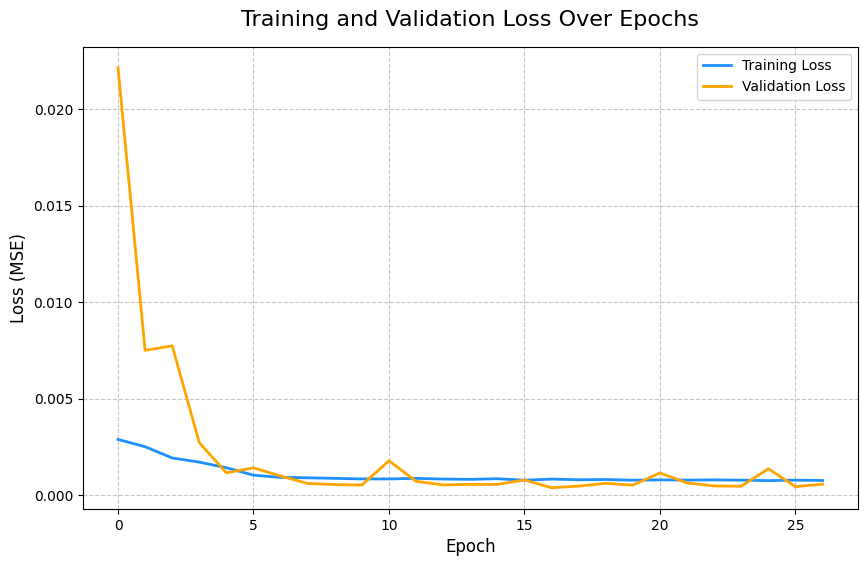

In [82]:
# Training and Validation Loss Plot

# Save training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='#1E90FF', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='#FFA500', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [81]:
# Model Predictions + Evaluation Metrics

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Root Mean Squared Error (RMSE): 6479.45
Mean Absolute Error (MAE): 4370.47


# **🙆 7. LSTM Model Prediction & Visualization**

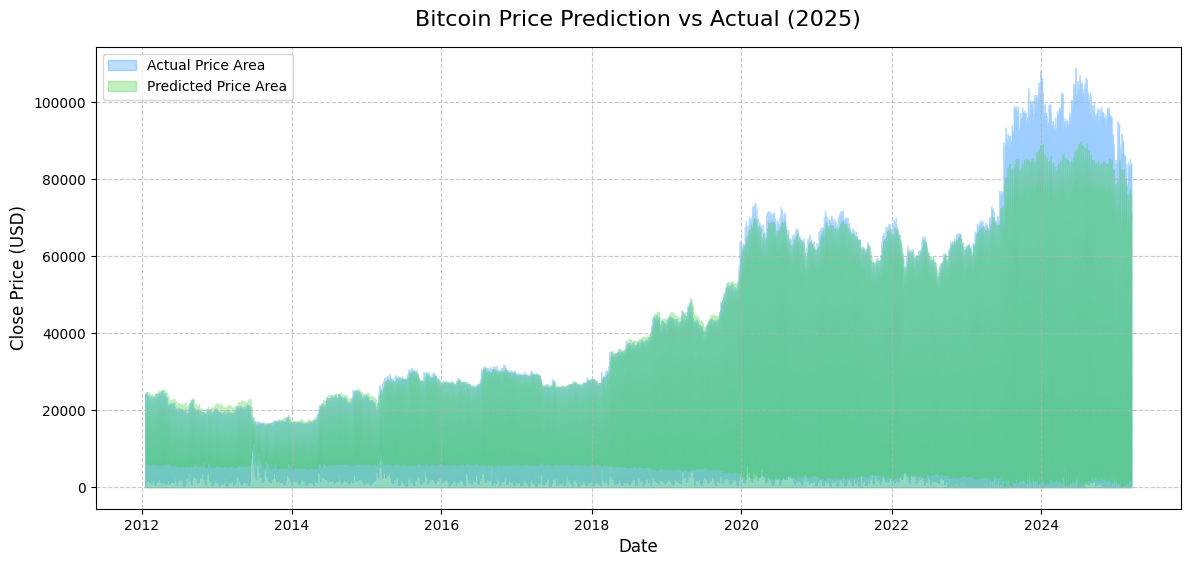

In [83]:
test_dates = daily_data.index[-len(y_test):]

plt.figure(figsize=(14, 6))
plt.fill_between(test_dates, y_test_inv.flatten(), color='#1E90FF', alpha=0.3, label='Actual Price Area')
plt.fill_between(test_dates, y_pred_inv.flatten(), color='#32CD32', alpha=0.3, label='Predicted Price Area')

plt.title('Bitcoin Price Prediction vs Actual (2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [84]:
# Save the model
model.save('bitcoin_lstm_model.h5')
print("Model saved as 'bitcoin_lstm_model.h5'")

Model saved as 'bitcoin_lstm_model.h5'


**Future Prediction (Next 5 Days)**

In [86]:
# Get the last sequence from the training data
last_sequence = scaled_data[-seq_length:].reshape((1, seq_length, 1))

# Generate predictions for the next 5 days
future_predictions = []
n_future = 10

current_sequence = last_sequence.copy()
for _ in range(n_future):
    next_pred = model.predict(current_sequence)
    future_predictions.append(next_pred[0, 0])
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred[0, 0]

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame with predicted dates and prices
last_date = daily_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price_USD': future_predictions.flatten()
})

# Display the DataFrame
print("\nPredicted Bitcoin Close Prices for the Next 5 Days:")
print(future_df.to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Predicted Bitcoin Close Prices for the Next 5 Days:
                     Date  Predicted_Close_Price_USD
2025-03-16 00:00:00+00:00               75213.460938
2025-03-17 00:00:00+00:00               78579.039062
2025-03-18 00:00:00+00:00               70833.187500
2025-03-19 00:00:00+00:00               74298.085938
2025-03-20 00:00:00+00:00                6339.724121
2025-03-21 00:00:00+00:00               65056.554688
2025-03-22 00:00:00+00:00               69414.367188
2025-03-23 00:00:00+00:00               64207.851562
2025-03-24 00:00:00+00:00               63784.148438
2025-03-25 00:00:00+00:00            